In [49]:
import pandas as pd
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline
import xgboost as xgb

from sklearn.model_selection import train_test_split

import numpy as np
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import witwidget

from witwidget.notebook.visualization import WitWidget, WitConfigBuilder

plt.rcParams["figure.figsize"] = (20,10)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("gs://churn-model-sri/telecom_customer_churn.csv")

In [3]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [4]:
df['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [5]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=124)

In [7]:
drop_feat=  ['customerID','gender','PhoneService','MultipleLines', 'PaperlessBilling','PaymentMethod']
numeric_features = ['tenure', 'TotalCharges']
categorical_features = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract']

In [8]:
drop_transformer = ColumnTransformer(transformers=[('drop_columns', 'drop', drop_feat)], remainder='passthrough')

In [9]:
df.isna().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [10]:
numeric_transformer = Pipeline(steps=[
                                     ('meanimputer', SimpleImputer(strategy='mean')),
                                     ])

categorical_transformer = Pipeline(steps=[
                                         ('onehotenc', OneHotEncoder(handle_unknown='ignore'))
                                         ])

In [11]:
col_transformer = ColumnTransformer(transformers=[('drop_columns', 'drop', drop_feat),
                                                   ('numeric_processing',numeric_transformer, numeric_features),
                                                    ('categorical_processing', categorical_transformer, categorical_features)
                                                  ], remainder='drop')

In [12]:
pipeline = Pipeline([
                     ('transform_column', col_transformer),
                    ])

In [13]:
pipeline.fit(X_train)

Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['customerID', 'gender',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('numeric_processing',
                                                  Pipeline(steps=[('meanimputer',
                                                                   SimpleImputer())]),
                                                  ['tenure', 'TotalCharges']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('onehotenc',
                                                              

In [14]:
transformed_train=pipeline.transform(X_train)

In [15]:
transformed_train.shape

(5634, 34)

In [16]:
pd.DataFrame(transformed_train)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,5.0,302.60,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,12.0,442.45,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,70.0,7968.85,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,74.60,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,17.0,1607.20,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,8.0,551.95,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5630,43.0,1188.20,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5631,7.0,533.60,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5632,2.0,98.50,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [17]:
pipeline.transform(X_test)

array([[7.10000e+01, 7.69090e+03, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [4.00000e+00, 3.03150e+02, 1.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.40000e+01, 1.34850e+03, 1.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [3.70000e+01, 3.41525e+03, 1.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00],
       [6.10000e+01, 1.55490e+03, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 1.00000e+00],
       [7.00000e+00, 2.65800e+02, 0.00000e+00, ..., 1.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [18]:
pipeline.named_steps['transform_column'].transformers_[2][1]

Pipeline(steps=[('onehotenc', OneHotEncoder(handle_unknown='ignore'))])

In [19]:
cat_cols=pipeline.named_steps['transform_column'].transformers_[2][1].named_steps['onehotenc'].get_feature_names(categorical_features)

In [20]:
feature_names=numeric_features+cat_cols.tolist()

In [21]:
pd.DataFrame(transformed_train, columns=feature_names)

,tenure,TotalCharges,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,...,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year
0,5.0,302.60,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,12.0,442.45,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,70.0,7968.85,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,74.60,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,17.0,1607.20,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,8.0,551.95,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5630,43.0,1188.20,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5631,7.0,533.60,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5632,2.0,98.50,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [22]:
scale_pos_weight=y_train.value_counts()[0]/y_train.value_counts()[1]

In [23]:
scale_pos_weight

2.768561872909699

In [24]:
pipeline_xgb = Pipeline([
                     ('transform_column', col_transformer),
                     ('xgboost', xgb.XGBClassifier())
                    ])

In [25]:
pipeline_xgb.fit(X_train,y_train)

[21:01:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('transform_column',
                 ColumnTransformer(transformers=[('drop_columns', 'drop',
                                                  ['customerID', 'gender',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('numeric_processing',
                                                  Pipeline(steps=[('meanimputer',
                                                                   SimpleImputer())]),
                                                  ['tenure', 'TotalCharges']),
                                                 ('categorical_processing',
                                                  Pipeline(steps=[('onehotenc',
                                                              

In [26]:
pipeline_xgb.score(X_test,y_test)

0.7920511000709723

In [27]:
y_pred = pipeline_xgb.predict(X_test)

In [28]:
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
confusion_matrix(y_test, y_pred)

array([[936,  99],
       [194, 180]])

In [30]:
print(classification_report(y_test, y_pred, labels=['No','Yes']))

              precision    recall  f1-score   support

          No       0.83      0.90      0.86      1035
         Yes       0.65      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [50]:
model=pipeline_xgb.named_steps['xgboost']
model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [51]:
def plotImp(model, X , num = 20):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 3)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('XGBoost Feature Importance')
    plt.tight_layout()
    plt.show()

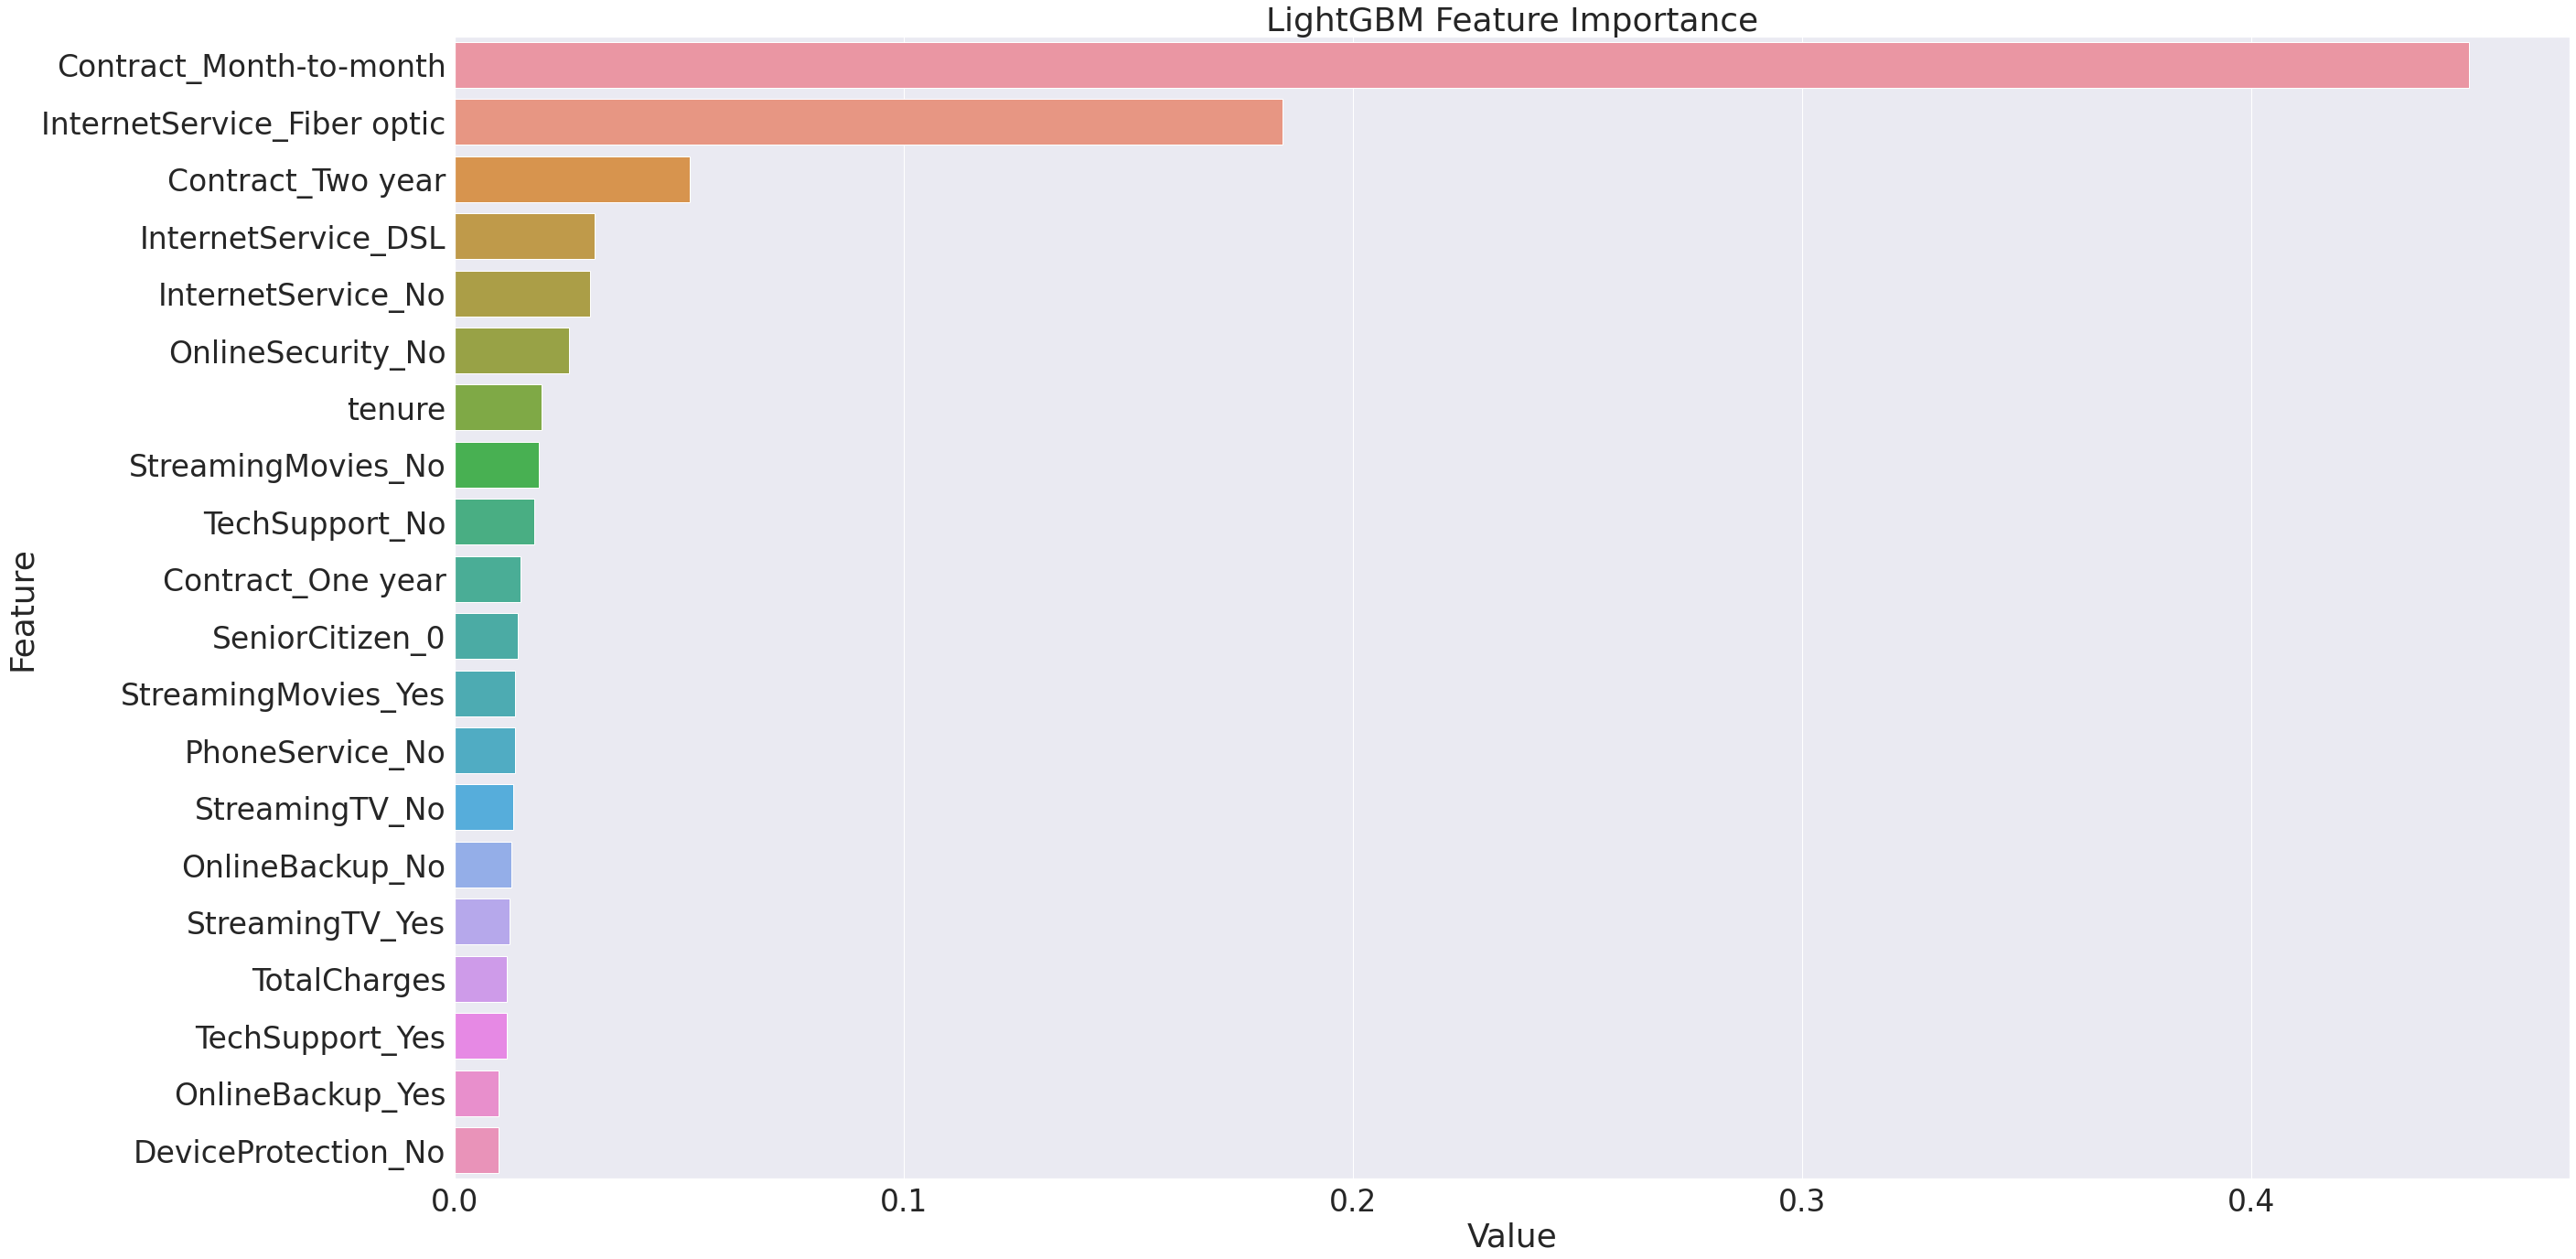

In [52]:
plotImp(model, feature_names)

In [34]:
joblib.dump(pipeline_xgb, 'model.joblib')

['model.joblib']

In [35]:
BUCKET_NAME="churn-model-sri"

In [36]:
REGION="us-west1"

In [37]:
!echo $REGION

us-west1


In [38]:
!gcloud config set project srivatsan-project

Updated property [core/project].


In [39]:
!gsutil mb -l $REGION gs://$BUCKET_NAME

Creating gs://churn-model-sri/...
ServiceException: 409 Bucket churn-model-sri already exists.


In [40]:
!gsutil cp ./model.joblib gs://$BUCKET_NAME/model.joblib

Copying file://./model.joblib [Content-Type=application/octet-stream]...
/ [1 files][352.8 KiB/352.8 KiB]                                                
Operation completed over 1 objects/352.8 KiB.                                    


In [41]:
model = joblib.load("./model.joblib")

In [42]:
instance = ["7317-GGVPB", "Male", 0, "Yes", "No", 71, "Yes", "Yes", "Fiber optic", "No", "Yes", "Yes", "Yes", "Yes", "Yes", "Two year", "Yes", "Credit card (automatic)", 108.6, "7690.9"]
_COLUMN_NAMES=['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod', 'MonthlyCharges', 'TotalCharges']

In [43]:
model.predict(pd.DataFrame(data=[instance], columns=_COLUMN_NAMES))

array(['No'], dtype=object)

In [ ]:
import json

In [ ]:
json.dumps(X_test[0:2].values.tolist())